In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,f1_score

import pickle

In [2]:
df = pd.read_csv('Fraud.csv',index_col=False)

In [3]:
df_copy = df.copy()

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.sample()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
663877,36,CASH_OUT,390466.83,C1414659546,20836.0,0.0,C1808051559,2805191.34,2858961.79,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## There are no null values

In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


<Axes: xlabel='step', ylabel='isFraud'>

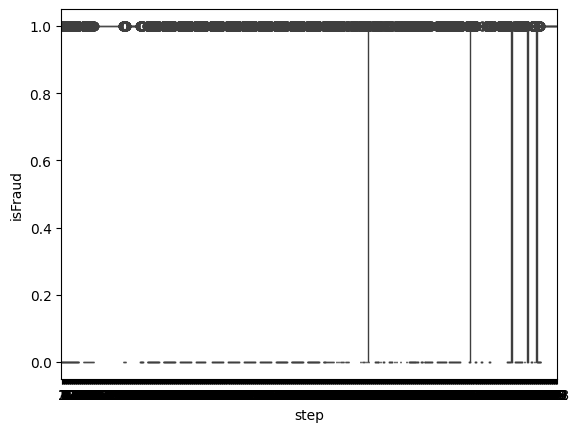

In [8]:
#sns.boxplot(x=df['step'],y=df['isFraud'])

### Checking correlation of input column wiht output column to get an insight that which columns are useful and how to compare between columns

In [10]:
for column in df.columns:
    if(column=='isFraud'):
        continue
    else:
        try:
            print('correlation with ',column,'is :',df[column].corr(df['isFraud']))
        except:
            print("Error Occured in column :",column)

correlation with  step is : 0.03157756863269222
Error Occured in column : type
correlation with  amount is : 0.07668842884029378
Error Occured in column : nameOrig
correlation with  oldbalanceOrg is : 0.010154421850334374
correlation with  newbalanceOrig is : -0.00814816126757101
Error Occured in column : nameDest
correlation with  oldbalanceDest is : -0.005885278228052588
correlation with  newbalanceDest is : 0.0005353470683179225
correlation with  isFlaggedFraud is : 0.04410919651381388


In [ ]:
sns.heatmap(df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest',
                'newbalanceDest', 'isFraud','isFlaggedFraud']].corr(),
            annot=True
           )
plt.show()

Huge multicollinearity can be seen between the columns oldbalanceOrg , newbalanceOrg  and oldbalanceDest,newbalanceDest

## ISFRAUD  

In [11]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64


Clearly the data given is imbalanced as the category '0' dominated the category '1'


In [23]:
df[df['isFraud'] == 1]['newbalanceDest'].value_counts()

newbalanceDest
0.00           4091
10000000.00      53
127905.82         2
429257.45         2
1064995.85        2
               ... 
10612.55          1
1658746.09        1
143675.35         1
438233.86         1
9281535.44        1
Name: count, Length: 4067, dtype: int64

In [19]:
df[df['isFraud'] == 1]['newbalanceOrig'].value_counts()

newbalanceOrig
0.00           8053
10399045.08       3
17316255.05       3
19585040.37       3
1343002.08        2
               ... 
27316255.05       1
1314660.84        1
35674547.89       1
25674547.89       1
15674547.89       1
Name: count, Length: 145, dtype: int64

<span style="color: yellow;">Around 99% of isFraud values as '1' occrus when the newbalanceOrig is zero .i.e all money from the sender side is extracted</span>

In [31]:
df[df['isFraud'] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


In [14]:
skewness = df['isFraud'].skew()
kurtosis = df['isFraud'].kurt()
print(skewness, kurtosis)


27.779538153063452 769.7029819428034


<span style=color:yellow>The high value of skewnwess and kurtosis refers the imbalancement in our output column</span>

In [17]:
df.shape

(6362620, 11)

## ISFLAGGEDFRAUD

In [26]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [27]:
df[df['isFlaggedFraud'] == 1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


<span style=color:yellow>There is a problem in the isFlaggedFraud as 99.9% values belong to '0' and only 16 values out of 6 lakh values are 1.
For all the isFlaggedFraud =1 the isFraud =1 ..Therefore the column ifFlaggedFraud is not important for our model.also its correlation with output column isFraud is very less .Therefore we can remove this column</span>

## Amount

In [8]:
df['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

In [10]:
df[df['amount'] > 7.487194e+04]['isFraud'].value_counts()

isFraud
0    3174503
1       6807
Name: count, dtype: int64

<span style=color:yellow>

<span style=color:yellow>82% of the total fraud occured when transaction amount was more than 7.487194e+04 i.e above which 50% of the datapoints lies</span>

In [11]:
df[df['amount'] >  2.087215e+05]['isFraud'].value_counts()

isFraud
0    1585251
1       5404
Name: count, dtype: int64

<Axes: xlabel='amount'>

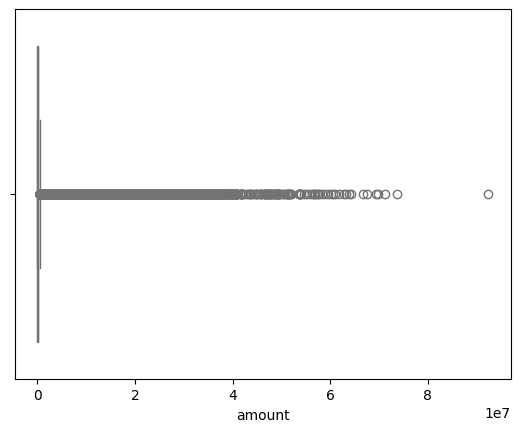

In [34]:
sns.boxplot(x=df['amount'],color='lightgreen')

<span style=color:yellow>As mostly the fraud occured for higher value of amount .Therefore higher values of amount are important for output prediction and cannot be considered as outlier</span>

In [ ]:
df[df['amount'] == df['oldbalanceOrg']]['isFraud'].value_counts()

isFraud
1    8034
Name: count, dtype: int64

Whenever the transaction amount is equal to the old balance in the orginal account 100% fraud cases are detected

## TYPE

In [ ]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

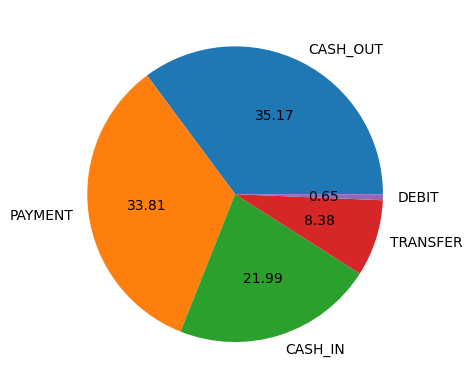

In [ ]:
plt.pie(x=df['type'].value_counts(),autopct='%.2f',labels=['CASH_OUT','PAYMENT','CASH_IN','TRANSFER','DEBIT'])
plt.show()

CASH_OUT AND PAYMENT FORMS THE MAJORITY PART OF THE DATA i.e around 69%

In [ ]:
df[(df['type']=='PAYMENT') | (df['type']=='CASH_OUT')]['isFraud'].value_counts()

isFraud
0    4384879
1       4116
Name: count, dtype: int64

In [ ]:
df[(df['type']=='PAYMENT')]['isFraud'].value_counts()

isFraud
0    2151495
Name: count, dtype: int64

No fraud transcation are made when payment type was transfer

In [ ]:
df[(df['type']=='CASH_OUT')]['isFraud'].value_counts()

isFraud
0    2233384
1       4116
Name: count, dtype: int64

out of all the fraud transaction 50% of the fraud transaction are made in payment type cash_out

## STEP

In [11]:
df['step'].value_counts()

step
19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
725        4
655        4
246        4
662        2
112        2
Name: count, Length: 743, dtype: int64

<Axes: xlabel='step', ylabel='Count'>

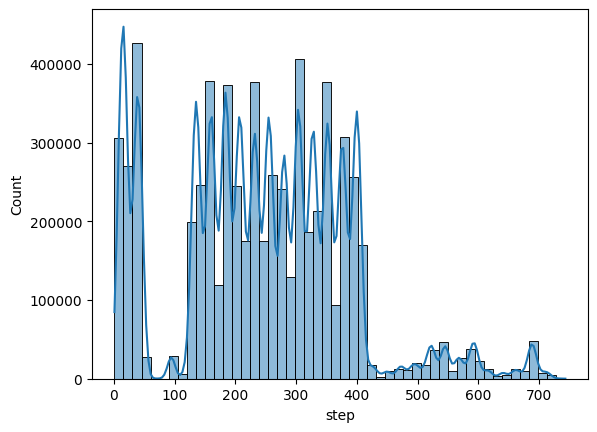

In [13]:
sns.histplot(df['step'],bins=50,kde=True)

<span style=color:yellow>The histplot shows that maximum part of the data lies between step values less than 400</span>

<Axes: ylabel='step'>

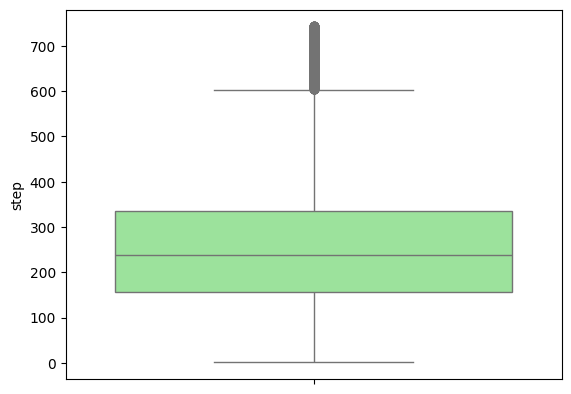

In [15]:
sns.boxplot(df['step'],color='lightgreen')

In [16]:
df[df['step'] > 600]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6259047,601,PAYMENT,115.00,C396363347,50.00,0.00,M1137898995,0.00,0.00,0,0
6259048,601,PAYMENT,23302.85,C1505891415,0.00,0.00,M1672214987,0.00,0.00,0,0
6259049,601,PAYMENT,2180.34,C1957624179,39492.00,37311.66,M545781624,0.00,0.00,0,0
6259050,601,PAYMENT,1504.97,C1764634515,49660.00,48155.03,M1433921244,0.00,0.00,0,0
6259051,601,PAYMENT,4445.60,C1452402784,1612.00,0.00,M1228077565,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


<span style=color:yellow>According to the boxplot there are roughly 1 lakh outlier values for step column</span>

## NameOrig & NameDest

In [ ]:
df['nameOrig'].value_counts()

nameOrig
C1677795071    3
C1999539787    3
C724452879     3
C1976208114    3
C400299098     3
              ..
C1668034607    1
C992223106     1
C312737633     1
C1565612524    1
C1566511282    1
Name: count, Length: 6353307, dtype: int64

In [ ]:
df['nameDest'].value_counts()

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M295304806       1
M33419717        1
M1940055334      1
M335107734       1
M1757317128      1
Name: count, Length: 2722362, dtype: int64

In [ ]:
df['nameDest'].value_counts()[   df['nameDest'].value_counts() > 100]

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
Name: count, dtype: int64

In [ ]:
df[df['nameDest']=='C1286084959']['isFraud'].value_counts()

isFraud
0    113
Name: count, dtype: int64

### Dropping unuseful columns

In [4]:
df.drop(columns=['nameOrig','nameDest','isFlaggedFraud'],inplace=True)

In [18]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


# Model Selection

In [5]:
X = df.drop(columns=["isFraud"])
y = df['isFraud']

### Using OrdinalEncoder for categorical columns

In [21]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']),
        ('cat', OrdinalEncoder(), ['type'])
    ], 
    remainder='passthrough'
)

In [24]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier',XGBClassifier())
])

In [28]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')

In [29]:
scores.mean()

np.float64(0.9997810650329579)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [38]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['type'])])),
                ('regressor',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [39]:
y_pred = pipeline.predict(X_test)

In [40]:
accuracy_score(y_test,y_pred)

0.9997761928262257

### Using OneHotEncoder for categorical columns

In [25]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']),
        ('cat', OneHotEncoder(drop='first'), ['type'])
    ], 
    remainder='passthrough'
)

In [26]:
pipeline_1 = Pipeline([
    ('preprocessor',preprocessor),
    ('classifier',XGBClassifier())
])

In [27]:
pipeline_1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [28]:
y_hat = pipeline_1.predict(X_test)

In [29]:
print(accuracy_score(y_test,y_hat))
print(f1_score(y_test,y_hat))
print(recall_score(y_test,y_hat))

0.9997743068107163
0.9081136421807013
0.867481662591687


### <Baseline style=color:pink>Baseline model with XGBoost got an accuracy of 99.97%</span>

## Logistic Regression

In [35]:
pipeline_2 = Pipeline([
    ('preprocessor',preprocessor),
    ('classifier' , LogisticRegression())
])

In [36]:
pipeline_2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('classifier', LogisticRegression())])

In [37]:
y_hat = pipeline_2.predict(X_test)

In [38]:
print(accuracy_score(y_test,y_hat))
print(f1_score(y_test,y_hat))
print(recall_score(y_test,y_hat))

0.9991864986436405
0.5598639455782313
0.4024449877750611


### <Baseline style=color:pink>Logistic Regression is giving a accuracy of 99.91% in validation data</span>

# Random Forest

In [49]:
pipeline_3 = Pipeline([
    ('preprocessor',preprocessor),
    ('classifier',RandomForestClassifier())
])

In [50]:
pipeline_3.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('classifier', RandomForestClassifier())])

In [51]:
y_hat =pipeline_3.predict(X_test)

In [52]:
print(accuracy_score(y_test,y_hat))
print(f1_score(y_test,y_hat))
print(recall_score(y_test,y_hat))

0.9997202410327821
0.8802153432032301
0.7995110024449877


### <Baseline style=color:pink>Random Forest is giving a accuracy of 99.97% in validation data</span>

## Gradient Boosting

In [40]:
pipeline_4 = Pipeline([
    ('preprocessor',preprocessor),
    ('classifier',GradientBoostingClassifier())
])

In [41]:
pipeline_4.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('classifier', GradientBoostingClassifier())])

In [42]:
y_hat = pipeline_4.predict(X_test)

In [43]:
print(accuracy_score(y_test,y_hat))
print(f1_score(y_test,y_hat))
print(recall_score(y_test,y_hat))

0.9977782737300043
0.2277097902097902
0.25476772616136917


### <Baseline style=color:pink>Gradient Boosting is giving a accuracy of 99.77% in validation data</span>

## AdaBoost

In [44]:
pipeline_5 = Pipeline([
    ('preprocessor',preprocessor),
    ('classifier',AdaBoostClassifier())
])

In [45]:
pipeline_5.fit(X_train,y_train)

C:\Users\abhil\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('classifier', AdaBoostClassifier())])

In [46]:
y_hat = pipeline.predict(X_test)

In [47]:
print(accuracy_score(y_test,y_hat))
print(f1_score(y_test,y_hat))
print(recall_score(y_test,y_hat))

0.9977782737300043
0.2277097902097902
0.25476772616136917


### <Baseline style=color:pink>AdaBoost is giving a accuracy of 99.91% in validation data</span>

### Final Conclusions  
     There are no null values in the dataset  

     Multicollinearity exist between column (OldBalanceOrd,NewBalanceOrg) and (OldBalanceDest,NewBalanceDest)  

     Outliers are there in the dataset but those outliers play a important role in predicting the output  

     High multicollinearity can be seen between the columns oldbalanceOrg , newbalanceOrg  and oldbalanceDest,newbalanceDest  

     The data is imbalanced as the category '0' dominates the category '1' of isFraud attribute  

     Around 99% of isFraud values as '1' occurs when the newbalanceOrig is zero .i.e this column is important in predicting isFraud  

     Value of skewness and kurtosis of the ouput column (isFraud) is high representing non-unifrom distribution of data  

     99.9 % of the isFlaggedFraud corresponds to '0' in the isFraud column and only 16 values corresponds to '1' in isFraud.This implies that this column is not much important for output prediction ,also its correlation with the output columns depicts the same  

     82% of the total fraud occured when transaction amount was more than 7.487194e+04 i.e above which 50% of the datapoints lies  
 
     As mostly the fraud occured for higher value of amount .Therefore higher values of amount are important for output prediction and cannot be considered as outlier  

     Whenever the transaction amount is equal to the old balance in the orginal account 100% fraud cases are detected, which means whenever the customer is doing transaction with its data altogether then changes of fraud is high.  

     CASH_OUT AND PAYMENT FORMS THE MAJORITY PART OF THE DATA i.e around 69%  

     No fraud transcation are made when payment type was transfer  

     Out of all the fraud transaction 50% of the fraud transaction are made in payment type cash_out  


# Answers to assignment questions

## 1.)Data Cleaning  
#### Missing values- No missing values are there  
#### Outlier- Outliers are present is "Step" and "Amount" but not removed as it is important in output prediction
#### Multicollinearity - Exist between oldbalanceOrg , newbalanceOrg  and oldbalanceDest,newbalanceDest

## 2.)Fraud Detection Model  
#### Xgboost Model gives the best performance

## 3.)Variable Selection
#### Columns ['nameOrg','nameDest','isFlaggedFraud'] are removed while training the model  

## 4.)Model Performance
#### Xgboost model gives the best performance with an accuracy_score of 99.97% ,f1_score of 0.90 and recall_score of 0.86.Also the model Random Forest gives an accuracy of 99.97% but we prefer the xgboost model as its recall value is high.A high recall value will ensure that less 'Fraud cases' are incorrectly classified which could make our cutomers transaction safe.

## 5.)Key Factors Predicting Fraud
#### "newbalanceOrig","Amount" columns

## 6.)Reasons for Key Factors
#### 99% of isFraud lies under newbalanceOrig = 0 datapoints and High amount transaction increases the chances of fraud

## 7.) Prevention Stragegies
#### Not allowing transaction of all the amount balance at once if it is significantly high  

## 8.)Additional Implementation  
#### Monitoring changes in fraud patterns with greater precision is essential for enhancing the effectiveness and robustness of our model. In this context, recall becomes a critical factor; a high recall value indicates that we are accurately identifying fraud cases and not misclassifying them as non-fraud. Prioritizing recall over precision is crucial because we want to ensure that no fraud cases go undetected. While focusing on precision would minimize the misclassification of non-fraud cases as fraud, this is less of a concern since it doesn’t pose a significant risk to the customer.

## Exporting the XGBoost pipeline

In [ ]:
with open('xgb_pipeline.pkl','wb') as file:
    pickle.dump(pipeline_1,file)
